In [10]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [1]:
coins = ['KRW-USDT', 'KRW-BIGTIME', 'KRW-CVC', 'KRW-SHIB', 'KRW-DOGE', 'KRW-UXLINK', 'KRW-XRP', 'KRW-SOL', 'KRW-BTC']

In [2]:
len(coins)

9

In [3]:
import pyupbit

In [4]:
interval = 'minute1'
count = 3126000

In [6]:
import datetime

In [7]:
timestep = 1

In [11]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

KRW-USDT data loaded
KRW-USDT train start
1237/1237 [==============================] - 2s 1ms/step
KRW-USDT Train RMSE: 0.955797 Test RMSE: 0.919836
1/1 [==============================] - 0s 13ms/step
KRW-USDT Actual [[1401.]] Pred [[1401.4031]]
[1401.4031, 1401.8042, 1402.204, 1402.6022, 1402.9984, 1403.3932, 1403.786, 1404.1774, 1404.5667, 1404.9543, 1405.3401, 1405.724, 1406.1061, 1406.4862, 1406.8644, 1407.2406, 1407.6149, 1407.9873, 1408.3574, 1408.7256, 1409.0918, 1409.4558, 1409.8177, 1410.1775, 1410.5352, 1410.8906, 1411.2438, 1411.5948, 1411.9436, 1412.29] -> --------------------------------------------------
KRW-BIGTIME data loaded
KRW-BIGTIME train start
433/433 [==============================] - 1s 1ms/step
KRW-BIGTIME Train RMSE: 0.474035 Test RMSE: 0.855786
1/1 [==============================] - 0s 13ms/step
KRW-BIGTIME Actual [[248.]] Pred [[247.02672]]
[247.02672, 246.07886, 245.15506, 244.25406, 243.37463, 242.5157, 241.67622, 240.85524, 240.05188, 239.26529, 238.49469

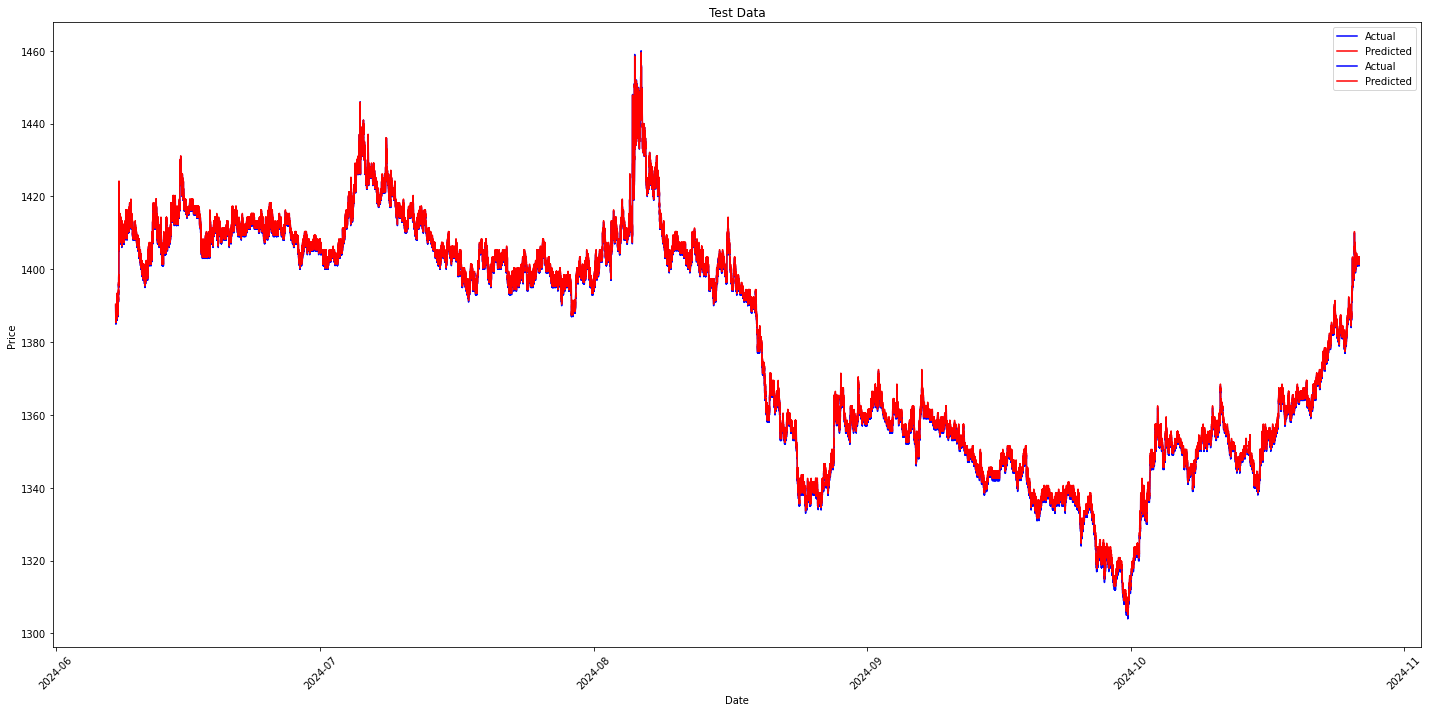

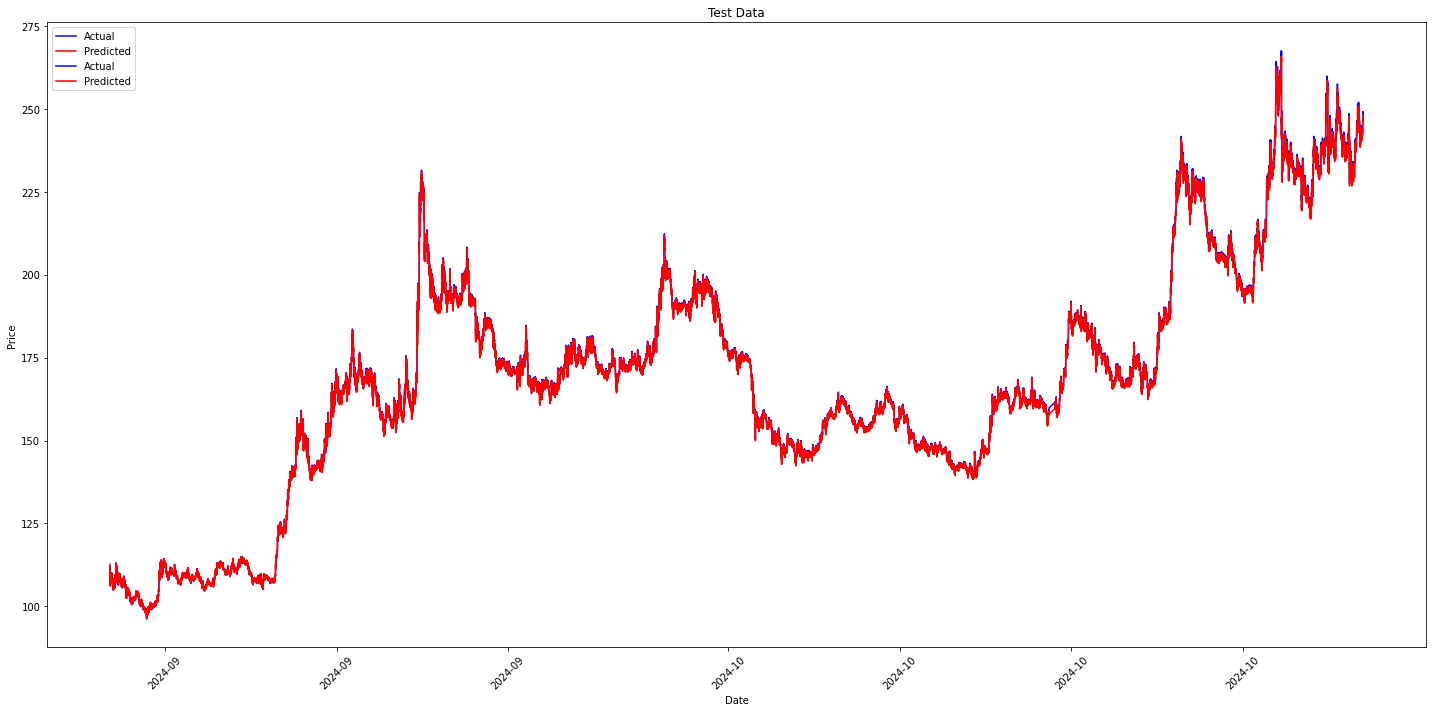

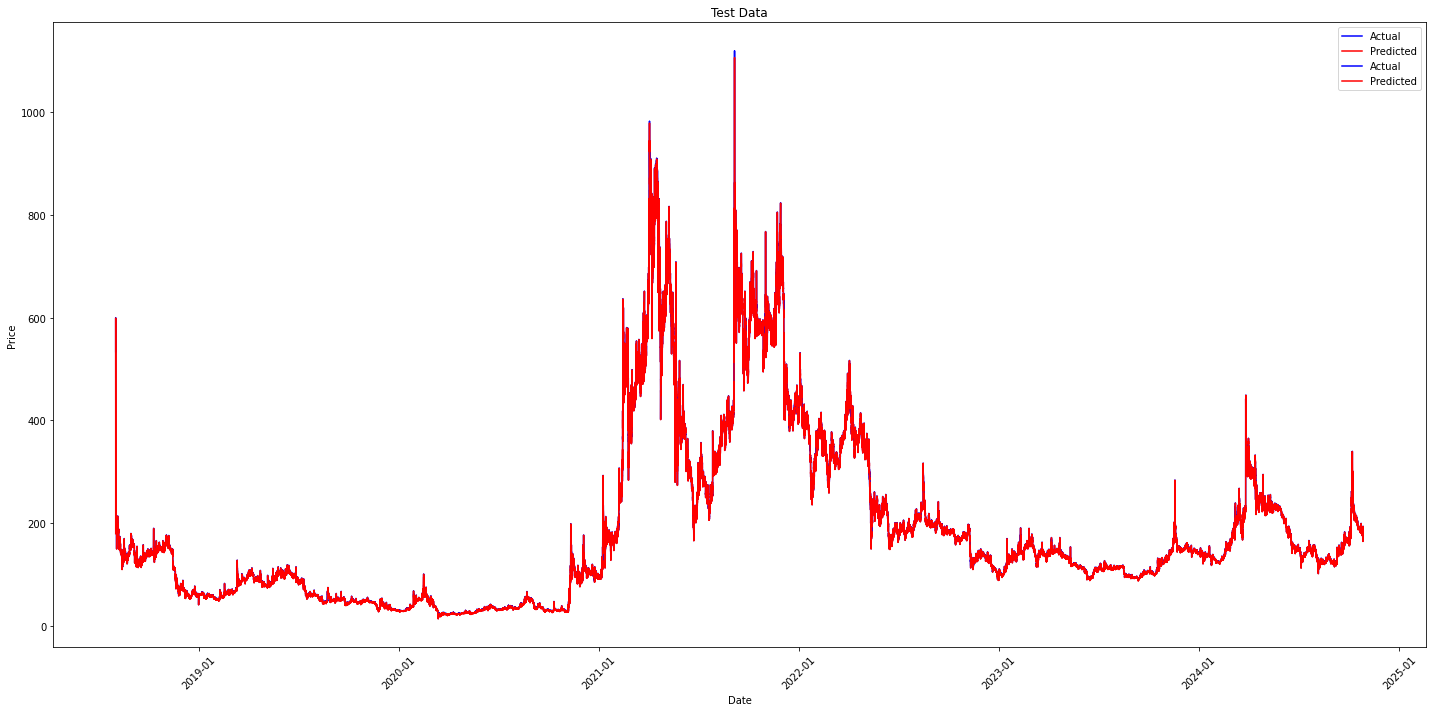

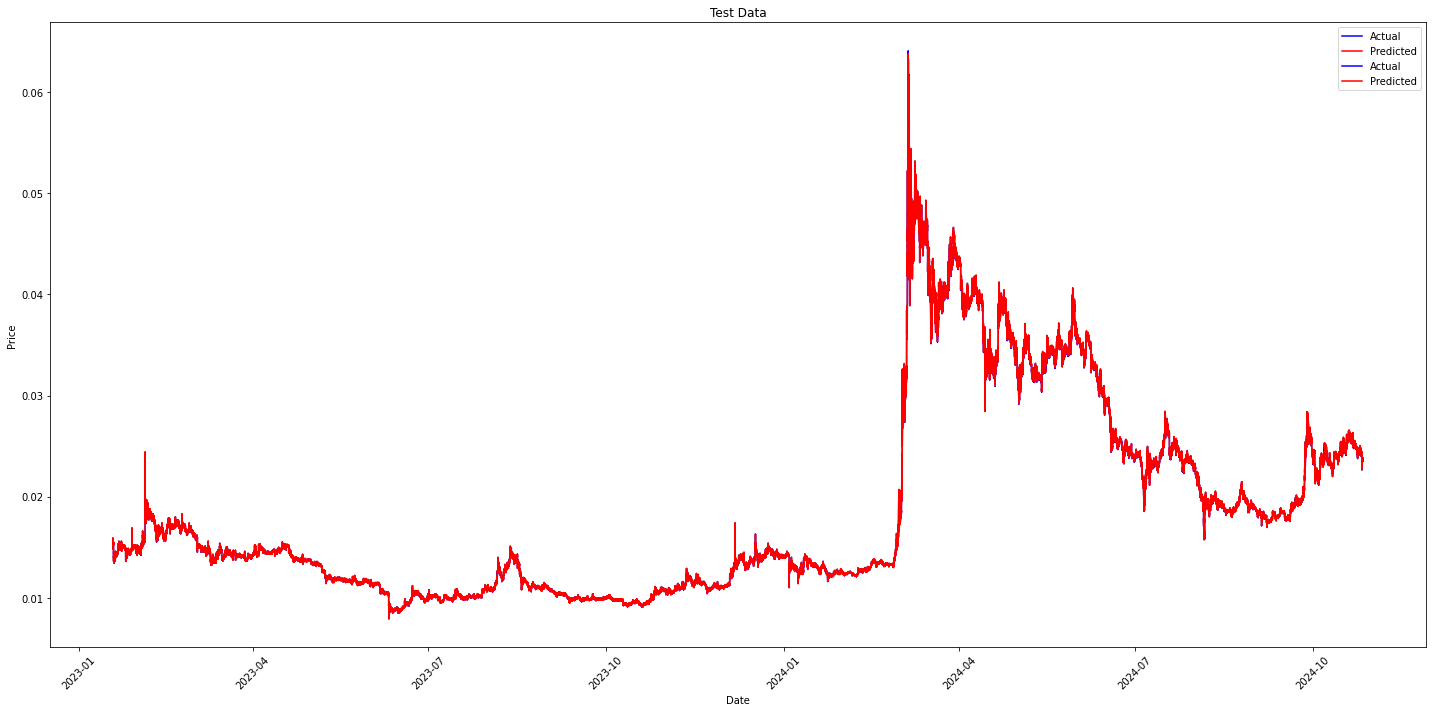

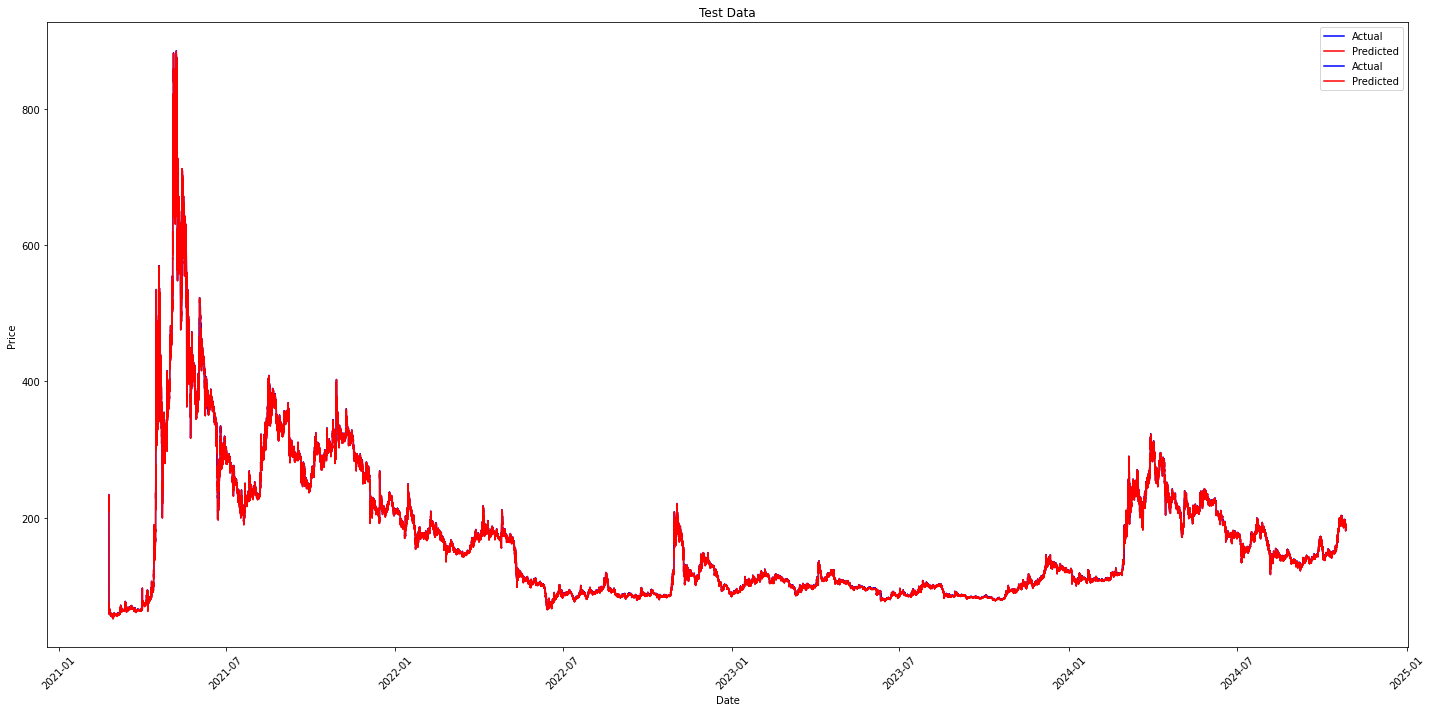

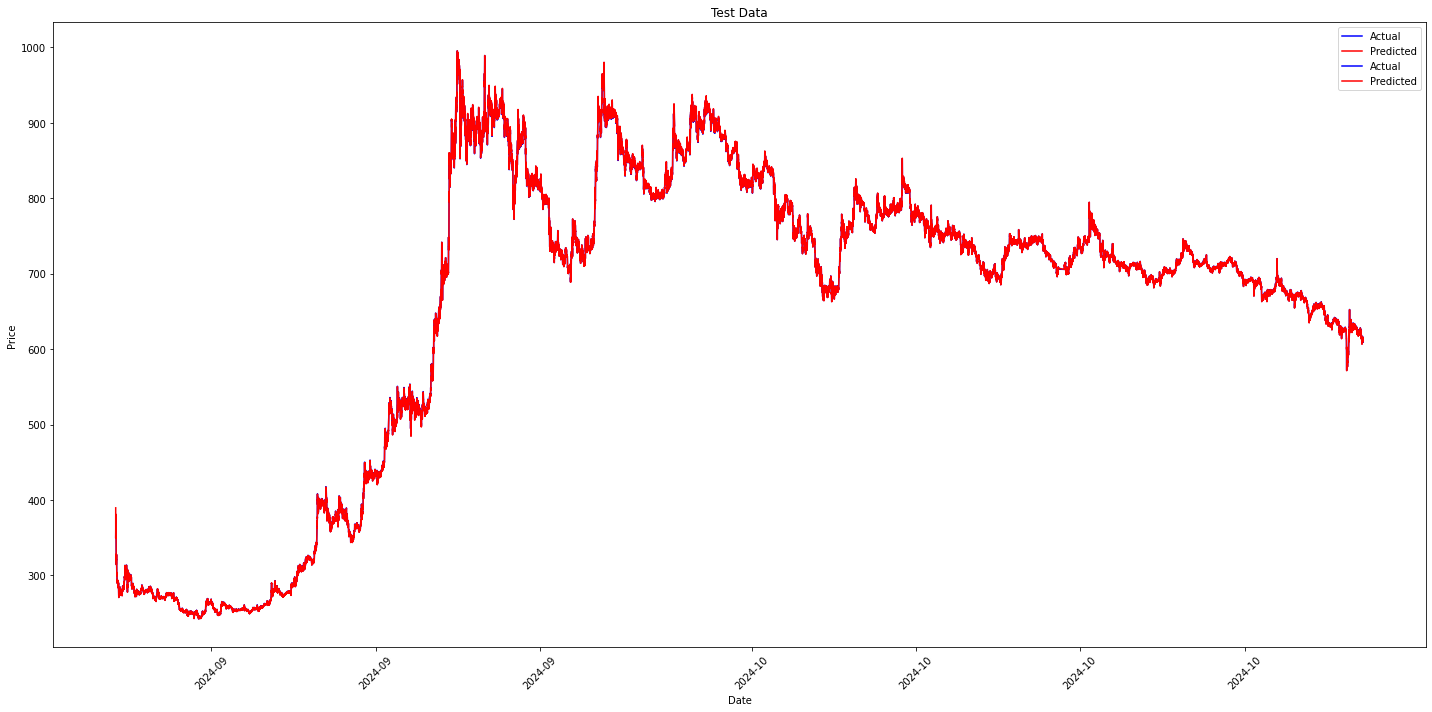

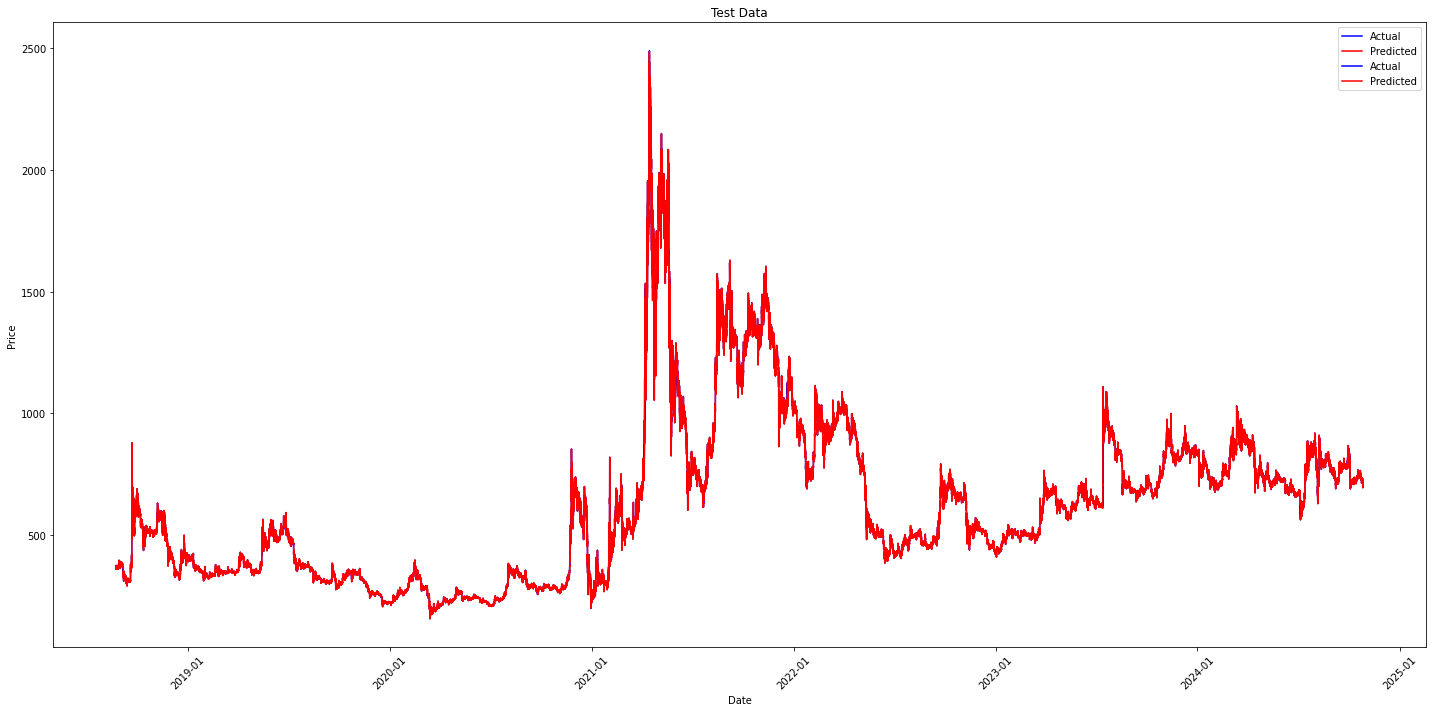

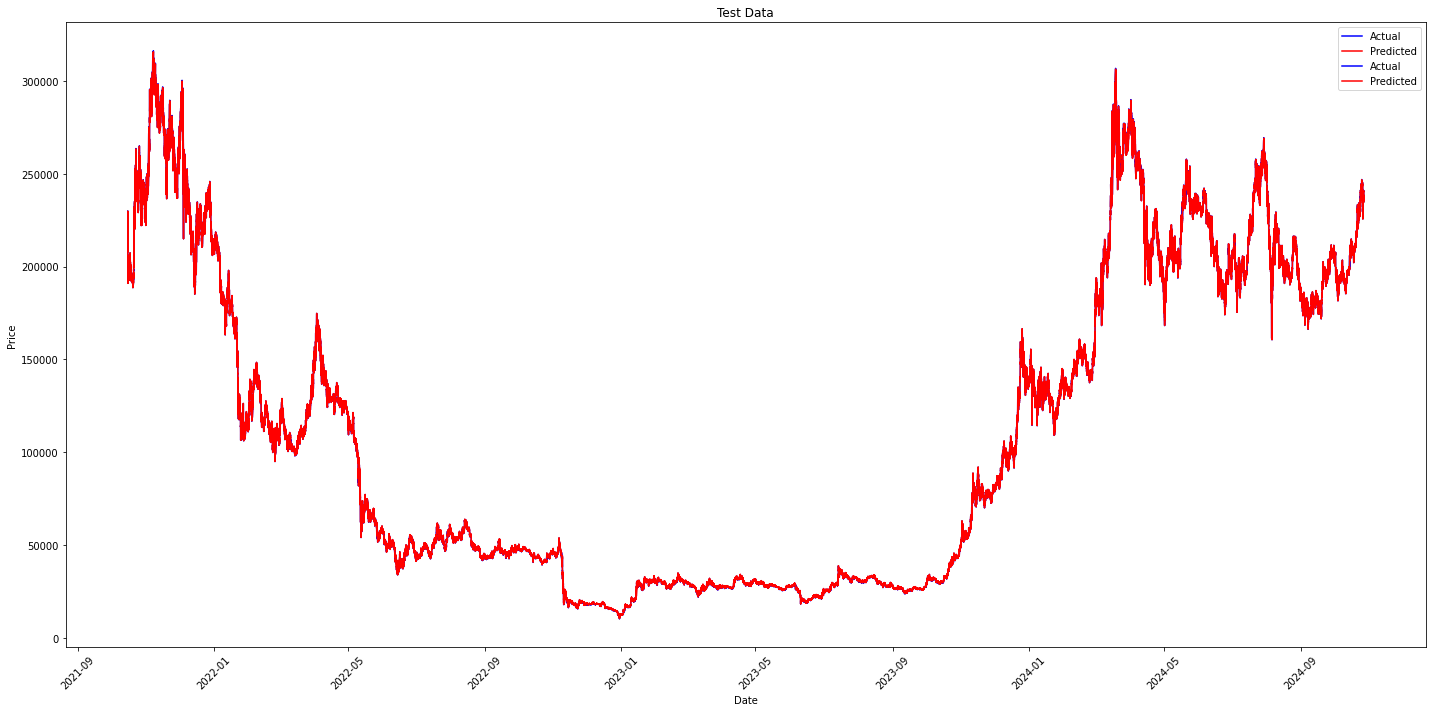

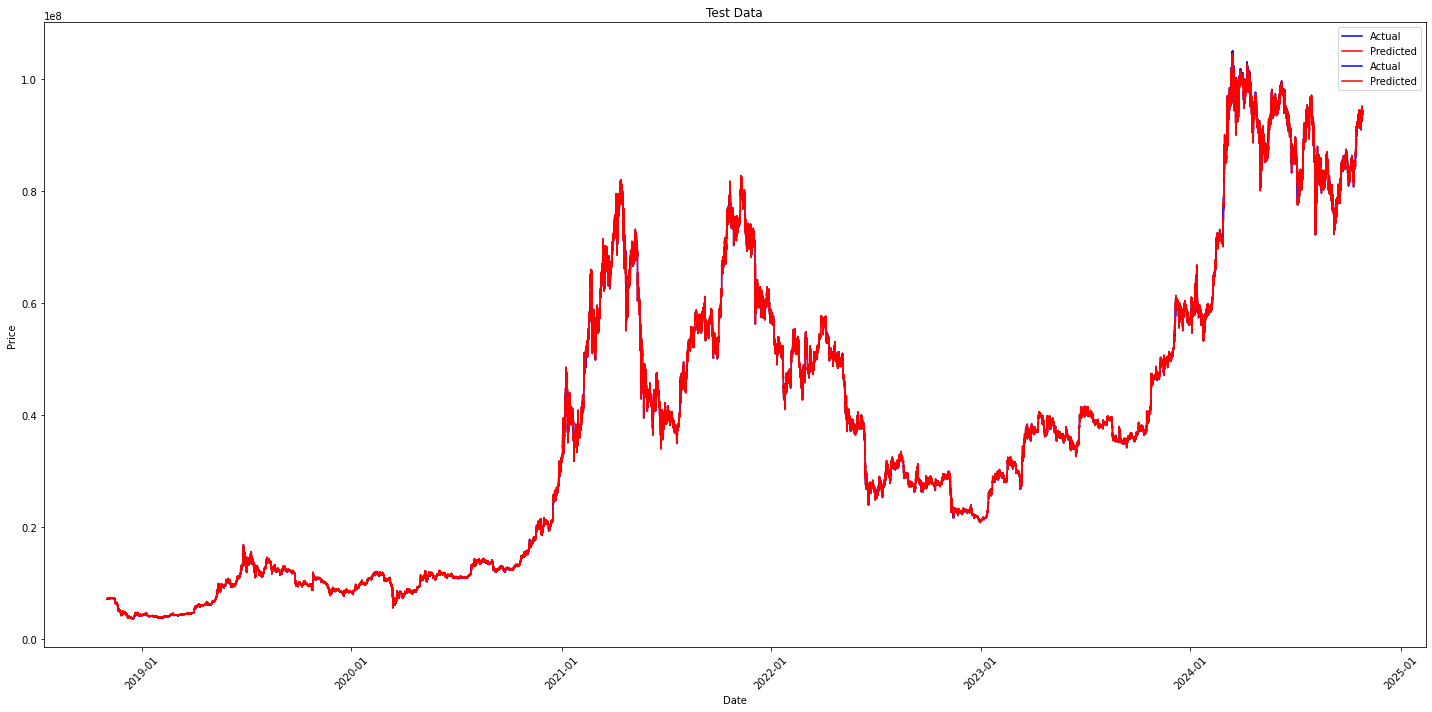

In [13]:
for ticker in coins:
    now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    df = pyupbit.get_ohlcv(ticker, interval=interval, count=count).reset_index().rename(columns={'index': 'timestamp'})
    df.to_csv(f'../data/from_pyupbit/{ticker}.csv', index=False)
    
    print(f'{ticker} data loaded')
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
    joblib.dump(scaler, f'models/{ticker}_scaler.pkl')
    
    X = []
    y = []
    for i in range(len(scaled_data) - timestep - 1):
        X.append(scaled_data[i:(i + timestep), 0])
        y.append(scaled_data[i + timestep, 0])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(X) * .8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    train_dates = df.index[:train_size]
    test_dates = df.index[train_size:]
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    
    print(f'{ticker} train start')
    
    model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
    
    model.save(f'models/lstm_{ticker}.h5')
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])
    
    train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
    test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
    print(f'{ticker} Train RMSE: {train_score:.6f} Test RMSE: {test_score:.6f}')
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 1, 1)
    plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
    plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
    plt.title('Train Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.savefig(f'models/{ticker}_train.png')
    
    plt.subplot(1, 1, 1)
    plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
    plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
    plt.title('Test Data')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.savefig(f'models/{ticker}_test.png')
    
    last_1_day = scaled_data[-timestep:]
    X_predict = last_1_day.reshape(1, timestep, 1)
    pred = model.predict(X_predict)
    pred = scaler.inverse_transform(pred)
    print(f'{ticker} Actual {scaler.inverse_transform(last_1_day)} Pred', pred)
    
    preds = []
    for i in range(30):
        pred = model.predict(X_predict, verbose=0)
        preds.append(scaler.inverse_transform(pred)[0][0])
        pred = pred.reshape(1, 1, 1)
        X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)